# Performance PR Analysis: AI Agents vs Humans, RQ1

## Setup and Data Loading

In [35]:
# Install dependencies
!pip install pandas numpy matplotlib seaborn scipy wordcloud pyarrow datasets --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
from collections import Counter
from datetime import datetime

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Plot settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Environment ready!")


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Environment ready!


In [36]:
# Compatibility shim: some versions of fsspec don't expose url_to_fs at top-level.
# This ensures code that expects fsspec.url_to_fs (used by some IO backends) continues to work.
try:
    import fsspec
    if not hasattr(fsspec, "url_to_fs"):
        try:
            from fsspec.core import url_to_fs as _url_to_fs
        except Exception:
            try:
                import fsspec.core as _core
                _url_to_fs = _core.url_to_fs
            except Exception:
                # Fallback shim: create a minimal url_to_fs that returns a filesystem and the path.
                def _url_to_fs(url, **kwargs):
                    protocol = url.split("://")[0] if "://" in url else "file"
                    fs = fsspec.filesystem(protocol)
                    return fs, url
        fsspec.url_to_fs = _url_to_fs
except Exception:
    # If anything goes wrong, continue without failing here; subsequent IO calls will raise their own errors.
    pass

In [37]:
human_pr_commit_details = pd.read_parquet("./datasets/human_pr/human_pr_commit_details.parquet")

human_pr_commit_details.head()

,sha,pr_id,pr_number,commit_stats_total,commit_stats_additions,commit_stats_deletions,filename,status,additions,deletions,changes,patch
0,d0f43c98b9a98bbacaa9a56f513bc97684d32ccc,2486573779,90516,20,6,14,src/sentry/utils/performance_issues/base.py,modified,3,6,9,"@@ -95,8 +95,9 @@ def visit_span(self, span: Span) -> None:\n def on_complete(self) -> None:..."
1,d0f43c98b9a98bbacaa9a56f513bc97684d32ccc,2486573779,90516,20,6,14,src/sentry/utils/performance_issues/detectors/experiments/n_plus_one_api_calls_detector.py,modified,2,1,3,"@@ -48,7 +48,8 @@ def __init__(self, settings: dict[DetectorType, Any], event: dict[str, Any]) -..."
2,d0f43c98b9a98bbacaa9a56f513bc97684d32ccc,2486573779,90516,20,6,14,src/sentry/utils/performance_issues/detectors/io_main_thread_detector.py,modified,0,5,5,"@@ -7,7 +7,6 @@\n import sentry_sdk\n from symbolic.proguard import ProguardMapper\n \n-from sen..."
3,d0f43c98b9a98bbacaa9a56f513bc97684d32ccc,2486573779,90516,20,6,14,src/sentry/utils/performance_issues/performance_detection.py,modified,1,2,3,"@@ -353,7 +353,7 @@ def _detect_performance_problems(\n detectors: list[PerformanceDetec..."
4,91d120e06968062bca53859a962c3b41456606fa,2486573779,90516,27,22,5,src/sentry/utils/performance_issues/base.py,modified,20,3,23,"@@ -96,7 +96,12 @@ def on_complete(self) -> None:\n pass\n \n @classmethod\n- def..."


In [38]:
human_pr_commits = pd.read_parquet("./datasets/human_pr/human_pr_commits.parquet")
human_pr_commits.head()

,sha,pr_id,pr_number,repo_owner,repo_name,author,committer,commit_message,pr_title,pr_description,pr_comments_count
0,d0f43c98b9a98bbacaa9a56f513bc97684d32ccc,2486573779,90516,getsentry,sentry,Leander Rodrigues,Leander Rodrigues,♻️ consolidate detection fallthroughs,ref(perf-issues): Consolidate File IO override option,This PR removes the `performance_issues.file_io_main_thread.disabled` override option for the Fi...,1
1,91d120e06968062bca53859a962c3b41456606fa,2486573779,90516,getsentry,sentry,Leander Rodrigues,Leander Rodrigues,🚚 rename creation -> detection + docs,ref(perf-issues): Consolidate File IO override option,This PR removes the `performance_issues.file_io_main_thread.disabled` override option for the Fi...,1
2,dc9d1965ce24fa1c89c194cfcdad2ba5e120060a,2419106029,87963,getsentry,sentry,Markus Unterwaditzer,Markus Unterwaditzer,ref(span-buffer): Move from sets to arrays\n\nArrays might be faster as they might not run compa...,ref(span-buffer): Move from sets to arrays,Arrays might be faster as they might not run comparisons on payloads to\ndetermine whether they ...,2
3,79e57d9480e0fa817fc1cdd0fa9ce9b99bace87d,2425248848,18585,oven-sh,bun,Dylan Conway,Dylan Conway,dont encode as double if possible,avoid encoding as double in `napi_create_double` if possible,### What does this PR do?\r\nArithmetic on numbers encoded as doubles in JSC seems to hit more s...,3
4,bdfde2a522d7982f7b9e37c7964b73abd4e82245,2613893429,20612,oven-sh,bun,Jarred Sumner,Jarred Sumner,Optimize `napi_get_value_string_utf8` `napi_get_value_string_latin1` `napi_get_value_string_utf16`,Optimize `napi_get_value_string_utf8` `napi_get_value_string_latin1` `napi_get_value_string_ut...,\r\n\r\n### What does this PR do?\r\n\r\nAvoid resolving string slices\r\n\r\nCheck for exceptio...,1


In [39]:
import pandas as pd
# Load datasets
print("Loading AIDev datasets...")

# AI Agent PRs
pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pull_request.parquet")
pr_task_type_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_task_type.parquet")
ai_perf_prs = (
    pr_df
    .merge(
        pr_task_type_df[["id", "type", "reason"]],
        on="id",
        how="inner"
    )
    .query("type == 'perf'")
    .copy()
)
ai_perf_prs['classification_reason'] = ai_perf_prs['reason']
ai_perf_prs['author_type'] = 'AI Agent'

# Human PRs
human_pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/human_pull_request.parquet")
human_pr_task_type_df = pd.read_parquet("hf://datasets/hao-li/AIDev/human_pr_task_type.parquet")
human_perf_prs = (
    human_pr_df
    .merge(
        human_pr_task_type_df[["id", "type", "reason"]],
        on="id",
        how="inner"
    )
    .query("type == 'perf'")
    .copy()
)
human_perf_prs['classification_reason'] = human_perf_prs['reason']
human_perf_prs['author_type'] = 'Human'
human_perf_prs['agent'] = 'Human'

# Store original counts
original_ai_count = len(ai_perf_prs)
original_human_count = len(human_perf_prs)

# Repository data for language info
all_repo_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_repository.parquet")

# Get list of performance PR IDs we care about
perf_pr_ids = set(ai_perf_prs['id'].tolist() + human_perf_prs['id'].tolist())
print(f"\n✓ Performance PR IDs to process: {len(perf_pr_ids):,}")

# PR commits details - FILTER FIRST, then aggregate
print("\nProcessing commit details (filtering to performance PRs only)...")
pr_commits_details = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_commit_details.parquet")

# Pr commit details for human PRs
human_pr_commit_details = pd.read_parquet("./datasets/human_pr/human_pr_commit_details_original.parquet")
human_pr_commits = pd.read_parquet("./datasets/human_pr/human_pr_commits_original.parquet")

# Extract only the columns you need from the second table
msg_df = human_pr_commits[["sha", "commit_message"]]

human_pr_commit_details = (
    human_pr_commit_details
        .merge(msg_df, on="sha", how="left")
)

human_pr_commit_details.rename(columns={"commit_message": "message"}, inplace=True)

pr_commits_details = pd.concat(
    [pr_commits_details, human_pr_commit_details],
    ignore_index=True
)

if 'pr_id' in pr_commits_details.columns:
    print(f"  Total commit records in dataset: {len(pr_commits_details):,}")
    
    # FILTER: Keep only commits for performance PRs
    pr_commits_filtered = pr_commits_details[pr_commits_details['pr_id'].isin(perf_pr_ids)].copy()
    print(f"  Filtered to performance PRs: {len(pr_commits_filtered):,} commit records")
    print(f"  Unique performance PRs with commits: {pr_commits_filtered['pr_id'].nunique():,}")
    
    # ADDITIONAL FILTERING: Remove commits with null filename
    if 'filename' in pr_commits_filtered.columns:
        before_filename_filter = len(pr_commits_filtered)
        pr_commits_filtered = pr_commits_filtered[pr_commits_filtered['filename'].notna()].copy()
        print(f"  Filtered out null filenames: {before_filename_filter - len(pr_commits_filtered):,} records removed")
        print(f"  Remaining after filename filter: {len(pr_commits_filtered):,} commit records")
        
    # ADDITIONAL FILTERING: Remove config/metadata-only files
    if 'filename' in pr_commits_filtered.columns:
        before_config_filter = len(pr_commits_filtered)
        
        # Define patterns for non-code files to exclude
        config_patterns = [
            r'^\.mvn/',                          # Maven wrapper configs
            r'^\.gradle/',                       # Gradle configs
            r'^\.idea/',                         # IntelliJ configs
            r'^\.vscode/',                       # VSCode configs
            r'^\.github/workflows/',             # GitHub Actions (unless it's code)
            r'\.properties$',                    # Properties files
            r'\.xml$',                           # XML config files (pom.xml, etc.)
            r'\.yml$',                           # YAML configs
            r'\.yaml$',                          # YAML configs
            r'\.json$',                          # JSON configs (package.json, etc.)
            r'\.md$',                            # Markdown docs
            r'\.txt$',                           # Text files
            r'\.gitignore$',                     # Git configs
            r'\.dockerignore$',                  # Docker ignore files
            r'/Dockerfile$',                     # Dockerfiles (anywhere in path)
            r'^Dockerfile$',                     # Dockerfile at root
            r'/docker-compose',                  # Docker compose (anywhere)
            r'^docker-compose',                  # Docker compose at root
            r'\.lock$',                          # Lock files (package-lock, yarn.lock)
            r'^LICENSE',                         # License files
            r'^README',                          # README files
        ]
        
        config_pattern = '|'.join(config_patterns)
        
        # Mark config files
        pr_commits_filtered['is_config_file'] = pr_commits_filtered['filename'].str.contains(
            config_pattern, case=False, na=False, regex=True
        )
        
        # Keep track of which files are code files per PR
        pr_commits_filtered['is_code_file'] = ~pr_commits_filtered['is_config_file']
        
        # For each PR, check if it has ANY code files
        pr_has_code = pr_commits_filtered.groupby('pr_id')['is_code_file'].any().reset_index()
        pr_has_code.columns = ['pr_id', 'has_code_files']
        
        # Filter to keep only PRs that have at least one code file
        pr_commits_filtered = pr_commits_filtered.merge(pr_has_code, on='pr_id', how='left')
        pr_commits_filtered = pr_commits_filtered[pr_commits_filtered['has_code_files']].copy()
        
        # Clean up temporary columns
        pr_commits_filtered = pr_commits_filtered.drop(columns=['is_config_file', 'is_code_file', 'has_code_files'])
        
        print(f"  Filtered out config-only commits: {before_config_filter - len(pr_commits_filtered):,} records removed")
        print(f"  Remaining after config filter: {len(pr_commits_filtered):,} commit records")
    
    # ADDITIONAL FILTERING: Remove merge commits
    if 'message' in pr_commits_filtered.columns:
        before_merge_filter = len(pr_commits_filtered)
        # Common merge commit patterns
        merge_patterns = [
            r'^Merge\s+branch',
            r'^Merge\s+pull\s+request',
            r'^Merge\s+remote-tracking\s+branch',
            r'^Merge\s+.*\s+into\s+',
            r"^Merged\s+in\s+",
        ]
        merge_pattern = '|'.join(merge_patterns)
        pr_commits_filtered = pr_commits_filtered[
            ~pr_commits_filtered['message'].str.match(merge_pattern, case=False, na=False)
        ].copy()
        print(f"  Filtered out merge commits: {before_merge_filter - len(pr_commits_filtered):,} records removed")
        print(f"  Remaining after merge filter: {len(pr_commits_filtered):,} commit records")

        # FINAL FILTER: drop PRs whose repositories were deleted
        deleted_repo_pr_ids = {3271610326, 3209206554}
        before_deleted_repo_filter = len(pr_commits_filtered)
        pr_commits_filtered = pr_commits_filtered[~pr_commits_filtered['pr_id'].isin(deleted_repo_pr_ids)].copy()
        removed_deleted_repo_commits = before_deleted_repo_filter - len(pr_commits_filtered)
        if removed_deleted_repo_commits > 0:
            print(f"  Removed deleted repo PR commits: {removed_deleted_repo_commits:,} records removed")
        print(f"  Remaining after deleted repo filter: {len(pr_commits_filtered):,} commit records")
    
    print(f"  Unique performance PRs after all filters: {pr_commits_filtered['pr_id'].nunique():,}")
    
    if len(pr_commits_filtered) > 0:
        # AGGREGATE: Now aggregate only the filtered commits
        commit_aggregated = pr_commits_filtered.groupby('pr_id').agg({
            'additions': 'sum',      # Total lines added across all commits
            'deletions': 'sum',      # Total lines deleted across all commits
            'patch': lambda x: '\n\n'.join([str(p) for p in x if pd.notna(p)])  # Concatenate all patches
        }).reset_index()
        
        # Add derived metrics
        commit_aggregated['num_commits'] = pr_commits_filtered.groupby('pr_id').size().values
        
        # Calculate patch length (for analysis)
        commit_aggregated['patch_length'] = commit_aggregated['patch'].str.len()
        
        print(f"  ✓ Aggregated to {len(commit_aggregated):,} unique performance PRs")
        print(f"  Avg commits per PR: {commit_aggregated['num_commits'].mean():.1f}")
        
        # Merge commit stats into AI Agent PR table
        ai_perf_prs = ai_perf_prs.merge(
            commit_aggregated,
            left_on='id',
            right_on='pr_id',
            how='left'
        )
        if 'pr_id' in ai_perf_prs.columns:
            ai_perf_prs = ai_perf_prs.drop(columns=['pr_id'])
        
        # Filter to keep only PRs with commit data
        ai_before_filter = len(ai_perf_prs)
        ai_with_commits = ai_perf_prs[ai_perf_prs['additions'].notna()].copy()
        print(f"  AI Agent PRs with commit data: {len(ai_with_commits):,} / {ai_before_filter:,} ({len(ai_with_commits)/ai_before_filter*100:.1f}%)")
        
        # Merge commit stats into Human PR table
        human_perf_prs = human_perf_prs.merge(
            commit_aggregated,
            left_on='id',
            right_on='pr_id',
            how='left'
        )
        if 'pr_id' in human_perf_prs.columns:
            human_perf_prs = human_perf_prs.drop(columns=['pr_id'])
        
        # Filter to keep only PRs with commit data
        human_before_filter = len(human_perf_prs)
        human_with_commits = human_perf_prs[human_perf_prs['additions'].notna()].copy()
        print(f"  Human PRs with commit data: {len(human_with_commits):,} / {human_before_filter:,} ({len(human_with_commits)/human_before_filter*100:.1f}%)")
    else:
        print("  ⚠ No commits found for performance PRs after filtering")
        # Create empty dataframes with same structure
        ai_with_commits = ai_perf_prs.iloc[0:0].copy()
        human_with_commits = human_perf_prs.iloc[0:0].copy()
    
else:
    print('⚠ pr_commit_details missing pr_id column; skipping commit merges.')
    # Create empty dataframes
    ai_with_commits = ai_perf_prs.iloc[0:0].copy()
    human_with_commits = human_perf_prs.iloc[0:0].copy()

print(f"\n{'='*80}")
print(f"SUMMARY")
print(f"{'='*80}")
print(f"Original Performance PRs:")
print(f"  AI Agent: {original_ai_count:,}")
print(f"  Human: {original_human_count:,}")
print(f"  Total: {original_ai_count + original_human_count:,}")
print(f"\nAfter Commit Filtering:")
print(f"✓ AI Agent Performance PRs: {len(ai_with_commits):,}")
print(f"✓ Human Performance PRs: {len(human_with_commits):,}")
print(f"✓ Total Performance PRs: {len(ai_with_commits) + len(human_with_commits):,}")

# Distribution by AI agent
if len(ai_with_commits) > 0:
    print(f"\nAI Agent Distribution:")
    for agent, count in ai_with_commits['agent'].value_counts().items():
        pct = count / len(ai_with_commits) * 100
        print(f"  {agent:20s} {count:5,d} ({pct:5.1f}%)")

# Commit statistics summary
if len(ai_with_commits) > 0 or len(human_with_commits) > 0:
    print(f"\n{'='*80}")
    print(f"COMMIT STATISTICS")
    print(f"{'='*80}")
    
    for author_type, df in [('AI Agent', ai_with_commits), ('Human', human_with_commits)]:
        if len(df) > 0:
            print(f"\n{author_type}:")
            print(f"  PRs with commit data: {len(df):,}")
            print(f"  Avg commits per PR: {df['num_commits'].mean():.1f}")
            print(f"  Median commits per PR: {df['num_commits'].median():.1f}")
            print(f"  Avg additions: {df['additions'].mean():.0f} lines")
            print(f"  Median additions: {df['additions'].median():.0f} lines")
            print(f"  Avg deletions: {df['deletions'].mean():.0f} lines")
            print(f"  Median deletions: {df['deletions'].median():.0f} lines")

print(f"\n{'='*80}")


Loading AIDev datasets...

✓ Performance PR IDs to process: 428

Processing commit details (filtering to performance PRs only)...
  Total commit records in dataset: 719,797
  Filtered to performance PRs: 15,284 commit records
  Unique performance PRs with commits: 427
  Filtered out null filenames: 46 records removed
  Remaining after filename filter: 15,238 commit records
  Filtered out config-only commits: 44 records removed
  Remaining after config filter: 15,194 commit records
  Filtered out merge commits: 10,166 records removed
  Remaining after merge filter: 5,028 commit records
  Removed deleted repo PR commits: 74 records removed
  Remaining after deleted repo filter: 4,954 commit records
  Unique performance PRs after all filters: 407
  ✓ Aggregated to 407 unique performance PRs
  Avg commits per PR: 12.2
  AI Agent PRs with commit data: 324 / 340 (95.3%)
  Human PRs with commit data: 83 / 88 (94.3%)

SUMMARY
Original Performance PRs:
  AI Agent: 340
  Human: 88
  Total: 428



## Data Preparation and Feature Engineering

In [40]:
# Combine AI and Human PRs
perf_prs = pd.concat([ai_with_commits, human_with_commits], ignore_index=True)

print(f"Combined dataset: {len(perf_prs):,} performance PRs")
print(f"  AI Agents: {(perf_prs['author_type'] == 'AI Agent').sum():,}")
print(f"  Humans: {(perf_prs['author_type'] == 'Human').sum():,}")

Combined dataset: 407 performance PRs
  AI Agents: 324
  Humans: 83


In [41]:
# Add language from repository table
print("Loading repository data for language information...")

if 'language' in all_repo_df.columns:
    # For AI Agent PRs: join on repo_id
    ai_mask = perf_prs['author_type'] == 'AI Agent'
    ai_prs = perf_prs[ai_mask].copy()
    human_prs = perf_prs[~ai_mask].copy()
    
    # Join AI PRs using repo_id
    if 'repo_id' in ai_prs.columns:
        ai_prs = ai_prs.merge(
            all_repo_df[['id', 'language']], 
            left_on='repo_id', 
            right_on='id', 
            how='left',
            suffixes=('', '_repo')
        )
        ai_prs['primary_language'] = ai_prs['language']
        if 'id_repo' in ai_prs.columns:
            ai_prs = ai_prs.drop(['id_repo'], axis=1)
        if 'language' in ai_prs.columns:
            ai_prs = ai_prs.drop(['language'], axis=1)
    
    # Join Human PRs using repo_url
    # Human PRs have repo_url, match with url from all_repo_df
    if 'repo_url' in human_prs.columns and 'url' in all_repo_df.columns:
        human_prs = human_prs.merge(
            all_repo_df[['url', 'language']], 
            left_on='repo_url',
            right_on='url',
            how='left',
            suffixes=('', '_repo')
        )
        human_prs['primary_language'] = human_prs['language']
        if 'url' in human_prs.columns:
            human_prs = human_prs.drop(['url'], axis=1)
        if 'language' in human_prs.columns:
            human_prs = human_prs.drop(['language'], axis=1)
    
    # Combine back together
    perf_prs = pd.concat([ai_prs, human_prs], ignore_index=True)
    
    ai_lang_count = perf_prs[perf_prs['author_type'] == 'AI Agent']['primary_language'].notna().sum()
    human_lang_count = perf_prs[perf_prs['author_type'] == 'Human']['primary_language'].notna().sum()
    
    print(f"✓ Language data joined!")
    print(f"  AI Agent PRs with language: {ai_lang_count:,}")
    print(f"  Human PRs with language: {human_lang_count:,}")
    print(f"  Total: {perf_prs['primary_language'].notna().sum():,} PRs with language info")
else:
    perf_prs['primary_language'] = None
    print("⚠ No language column in repository table")

Loading repository data for language information...
✓ Language data joined!
  AI Agent PRs with language: 324
  Human PRs with language: 82
  Total: 406 PRs with language info


In [42]:
# Convert date columns
for col in ['created_at', 'closed_at', 'merged_at']:
    if col in perf_prs.columns:
        perf_prs[col] = pd.to_datetime(perf_prs[col])

# Add derived status columns
perf_prs['is_merged'] = perf_prs['merged_at'].notna()
perf_prs['is_closed'] = perf_prs['closed_at'].notna()
perf_prs['is_open'] = perf_prs['state'] == 'open'

# Calculate time metrics
perf_prs['time_to_close_hours'] = (
    perf_prs['closed_at'] - perf_prs['created_at']
).dt.total_seconds() / 3600

perf_prs['time_to_merge_hours'] = (
    perf_prs['merged_at'] - perf_prs['created_at']
).dt.total_seconds() / 3600

perf_prs['time_to_close_days'] = perf_prs['time_to_close_hours'] / 24
perf_prs['time_to_merge_days'] = perf_prs['time_to_merge_hours'] / 24

# Text metrics
perf_prs['title_length'] = perf_prs['title'].str.len()
perf_prs['title_word_count'] = perf_prs['title'].str.split().str.len()
perf_prs['body_length'] = perf_prs['body'].str.len()
perf_prs['body_word_count'] = perf_prs['body'].str.split().str.len()
perf_prs['has_body'] = perf_prs['body'].notna() & (perf_prs['body'].str.strip() != '')

print("✓ Feature engineering complete")
print(f"  Merge rate: {perf_prs['is_merged'].mean()*100:.1f}%")
print(f"  PRs with descriptions: {perf_prs['has_body'].sum():,} ({perf_prs['has_body'].mean()*100:.1f}%)")

✓ Feature engineering complete
  Merge rate: 59.0%
  PRs with descriptions: 391 (96.1%)


## Overview: AI Agents vs Humans

In [43]:
# High-level comparison 
comparison_stats = perf_prs.groupby('author_type').agg({
    'id': 'count',
    'is_merged': ['sum', 'mean'],
    'time_to_merge_hours': ['mean', 'median'],
    'has_body': 'mean',
    'body_length': 'mean',
    'primary_language': 'nunique'
}).round(2)

comparison_stats.columns = [
    'Total PRs', 'Merged PRs', 'Merge Rate', 'Avg Time to Merge (hrs)', 
    'Median Time to Merge (hrs)', 'Body Rate', 'Avg Body Length',
    'Unique Languages'
]

comparison_stats['Merge Rate (%)'] = (comparison_stats['Merge Rate'] * 100).round(1)
comparison_stats['Body Rate (%)'] = (comparison_stats['Body Rate'] * 100).round(1)

print("="*100)
print("PERFORMANCE PR COMPARISON: AI AGENTS VS HUMANS")
print("="*100)
print(comparison_stats[[
    'Total PRs', 'Merge Rate (%)', 'Median Time to Merge (hrs)',
    'Body Rate (%)', 'Avg Body Length','Unique Languages'
]])

# Statistical test for merge rate difference
ai_merged = perf_prs[perf_prs['author_type'] == 'AI Agent']['is_merged']
human_merged = perf_prs[perf_prs['author_type'] == 'Human']['is_merged']

chi2, p_value = stats.chi2_contingency(
    pd.crosstab(perf_prs['author_type'], perf_prs['is_merged'])
)[:2]

print(f"\n📊 Statistical Test (Merge Rate Difference):")
print(f"  Chi-square: {chi2:.4f}")
print(f"  P-value: {p_value:.6f}")
print(f"  Significant: {'✓ Yes' if p_value < 0.05 else '✗ No'} (α=0.05)")

diff = comparison_stats.loc['AI Agent', 'Merge Rate (%)'] - comparison_stats.loc['Human', 'Merge Rate (%)']
print(f"  Effect: AI agents {'+' if diff > 0 else ''}{diff:.1f}% merge rate vs humans")

print("\n" + "="*100)

from scipy.stats import mannwhitneyu
import numpy as np

# ----------------------------------------
# Statistical test: Median time-to-merge
# ----------------------------------------

# Use merged PRs only
ai_time = perf_prs[
    (perf_prs['author_type'] == 'AI Agent') &
    (perf_prs['is_merged'] == 1)
]['time_to_merge_hours'].dropna()

human_time = perf_prs[
    (perf_prs['author_type'] == 'Human') &
    (perf_prs['is_merged'] == 1)
]['time_to_merge_hours'].dropna()

# Mann–Whitney U test (two-sided)
u_stat, p_time = mannwhitneyu(
    ai_time,
    human_time,
    alternative='two-sided'
)

# Cliff's delta for effect size
def cliffs_delta(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    return (np.sum(x[:, None] > y) - np.sum(x[:, None] < y)) / (len(x) * len(y))

delta = cliffs_delta(ai_time.values, human_time.values)

print("\n⏱️ Statistical Test (Median Time to Merge):")
print(f"  Mann–Whitney U: {u_stat:.2f}")
print(f"  P-value: {p_time:.6f}")
print(f"  Significant: {'✓ Yes' if p_time < 0.05 else '✗ No'} (α=0.05)")
print(f"  Cliff’s δ: {delta:.3f}")

direction = "faster" if np.median(ai_time) < np.median(human_time) else "slower"
print(
    f"  Effect: AI median time-to-merge is {direction} "
    f"({np.median(ai_time):.2f}h vs {np.median(human_time):.2f}h)"
)



PERFORMANCE PR COMPARISON: AI AGENTS VS HUMANS
             Total PRs  Merge Rate (%)  Median Time to Merge (hrs)  \
author_type                                                          
AI Agent           324           57.00                        0.03   
Human               83           65.00                        2.65   

             Body Rate (%)  Avg Body Length  Unique Languages  
author_type                                                    
AI Agent             99.00          1006.85                23  
Human                84.00          2068.60                15  

📊 Statistical Test (Merge Rate Difference):
  Chi-square: 1.2987
  P-value: 0.254457
  Significant: ✗ No (α=0.05)
  Effect: AI agents -8.0% merge rate vs humans


⏱️ Statistical Test (Median Time to Merge):
  Mann–Whitney U: 2150.00
  P-value: 0.000000
  Significant: ✓ Yes (α=0.05)
  Cliff’s δ: -0.572
  Effect: AI median time-to-merge is faster (0.03h vs 2.65h)


In [44]:
# Language frequency by author type
print("Top Languages by Author Type:")
print("=" * 80)

for author_type in ['AI Agent', 'Human']:
    subset = perf_prs[perf_prs['author_type'] == author_type]
    lang_counts = subset['primary_language'].value_counts().head(10)

    print(f"\n{author_type}:")
    for lang, count in lang_counts.items():
        pct = count / len(subset) * 100
        print(f"  {lang:15s} {count:4d} ({pct:5.1f}%)")

# Compare top languages (counts only, no merge info)
all_top_langs = list(set(
    perf_prs[perf_prs['author_type'] == 'AI Agent']['primary_language']
        .value_counts().head(8).index.tolist() +
    perf_prs[perf_prs['author_type'] == 'Human']['primary_language']
        .value_counts().head(8).index.tolist()
))

lang_comparison = []
for lang in all_top_langs:
    for author_type in ['AI Agent', 'Human']:
        subset = perf_prs[
            (perf_prs['author_type'] == author_type) &
            (perf_prs['primary_language'] == lang)
        ]
        if len(subset) > 0:
            lang_comparison.append({
                'Language': lang,
                'Author Type': author_type,
                'Count': len(subset)
            })

lang_df = pd.DataFrame(lang_comparison)

# Optional: pretty-print comparison table
print("\nLanguage Usage Comparison (Counts Only):")
print("=" * 80)
print(
    lang_df
    .pivot(index='Language', columns='Author Type', values='Count')
    .fillna(0)
    .astype(int)
    .sort_values(by=['AI Agent', 'Human'], ascending=False)
)


Top Languages by Author Type:

AI Agent:
  Go               120 ( 37.0%)
  TypeScript        66 ( 20.4%)
  Python            39 ( 12.0%)
  C#                24 (  7.4%)
  JavaScript        13 (  4.0%)
  Java              11 (  3.4%)
  Rust              10 (  3.1%)
  Kotlin             8 (  2.5%)
  MoonBit            6 (  1.9%)
  C++                6 (  1.9%)

Human:
  Python            20 ( 24.1%)
  TypeScript        19 ( 22.9%)
  Rust               9 ( 10.8%)
  Go                 7 (  8.4%)
  Ruby               6 (  7.2%)
  C#                 5 (  6.0%)
  Java               4 (  4.8%)
  Zig                3 (  3.6%)
  HTML               2 (  2.4%)
  F#                 2 (  2.4%)

Language Usage Comparison (Counts Only):
Author Type  AI Agent  Human
Language                    
Go                120      7
TypeScript         66     19
Python             39     20
C#                 24      5
JavaScript         13      1
Java               11      4
Rust               10      9
Kotlin  

# RQ4: Review Dynamics

In [48]:
# Review time analysis
merged_prs = perf_prs[perf_prs['is_merged']].copy()

review_stats = merged_prs.groupby('author_type')['time_to_merge_hours'].describe()
print("Review Time Statistics (Merged PRs):")
print("="*80)
print(review_stats)

# Statistical test
ai_times = merged_prs[merged_prs['author_type'] == 'AI Agent']['time_to_merge_hours'].dropna()
human_times = merged_prs[merged_prs['author_type'] == 'Human']['time_to_merge_hours'].dropna()

if len(ai_times) > 0 and len(human_times) > 0:
    statistic, p_value = stats.mannwhitneyu(ai_times, human_times, alternative='two-sided')
    print(f"\nMann-Whitney U test (time to merge):")
    print(f"  AI Agent median: {ai_times.median():.1f} hours ({ai_times.median()/24:.1f} days)")
    print(f"  Human median: {human_times.median():.1f} hours ({human_times.median()/24:.1f} days)")
    print(f"  P-value: {p_value:.6f}")
    print(f"  Significant: {'Yes' if p_value < 0.05 else 'No'} (α=0.05)")

Review Time Statistics (Merged PRs):
             count  mean    std  min  25%  50%   75%     max
author_type                                                 
AI Agent    186.00 14.36  54.80 0.00 0.00 0.03  0.68  494.23
Human        54.00 53.84 237.80 0.00 0.51 2.65 20.10 1747.19

Mann-Whitney U test (time to merge):
  AI Agent median: 0.0 hours (0.0 days)
  Human median: 2.7 hours (0.1 days)
  P-value: 0.000000
  Significant: Yes (α=0.05)


/var/folders/lj/l0_qr8g54f3b60v0fzt7bf200000gs/T/ipykernel_73459/4052456537.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


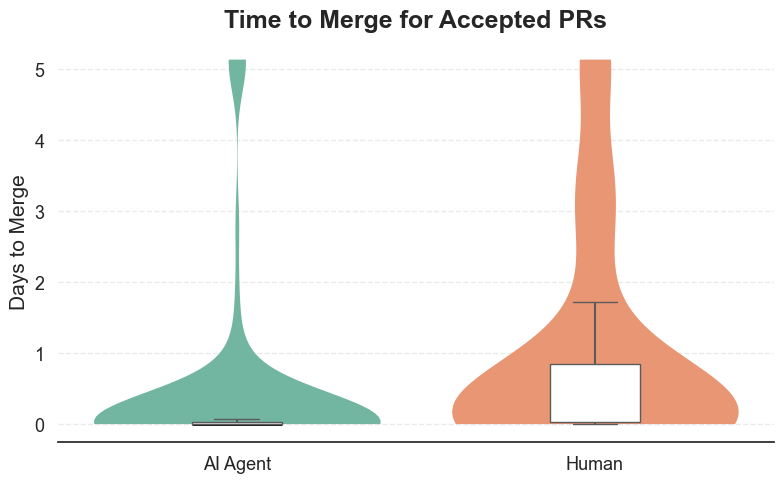

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# ----------------------------------------
# Global style: white background, larger fonts
# ----------------------------------------
sns.set_theme(
    style="white",
    rc={
        "figure.facecolor": "white",
        "axes.facecolor": "white",
        "savefig.facecolor": "white",
        "axes.titlesize": 18,
        "axes.labelsize": 15,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
    }
)

# ----------------------------------------
# Prepare data
# ----------------------------------------
plot_df = merged_prs[['author_type', 'time_to_merge_days']].dropna().copy()

# Clip extreme tail for visualization only
CLIP_Q = 0.95
upper = plot_df['time_to_merge_days'].quantile(CLIP_Q)
plot_df['plot_days'] = plot_df['time_to_merge_days'].clip(upper=upper)

# ----------------------------------------
# Plot
# ----------------------------------------
plt.figure(figsize=(8, 5))

ax = sns.violinplot(
    data=plot_df,
    x='author_type',
    y='plot_days',
    inner=None,
    cut=0,
    linewidth=0,
    palette='Set2'
)

sns.boxplot(
    data=plot_df,
    x='author_type',
    y='plot_days',
    width=0.25,
    showcaps=True,
    boxprops={'facecolor': 'white', 'zorder': 3},
    showfliers=False,
    whiskerprops={'linewidth': 1.5},
    medianprops={'color': 'black', 'linewidth': 2},
    ax=ax
)

# ----------------------------------------
# Labels & styling
# ----------------------------------------
ax.set_title(
    'Time to Merge for Accepted PRs',
    fontsize=18,
    fontweight='bold',
    pad=10
)
ax.set_xlabel('')
ax.set_ylabel('Days to Merge', fontsize=15)


ax.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine(left=True)

# Annotate medians
medians = (
    plot_df
    .groupby('author_type')['time_to_merge_days']
    .median()
)

plt.tight_layout()
plt.savefig(
    'review_time_distribution.png',
    dpi=300,
    bbox_inches='tight'
)
plt.show()
